# Binary star evolution

Figure 12.4 from Chapter 12 of *Stellar Structure & Evolution* Pinsonneault & Ryden, Cambridge University
Press.

Equipotential contours, in the orbital plane of the rotating frame of reference, for a pair of point masses
with mass ratio $q=M_2/M_1$=0.5. Units are chosen such that a=1, G(M<sub>1</sub>+M<sub>2</sub>)=1, and 
thus $\Omega_0$=1, same a Figure 12.3

Now fill in contours for 4 phases of binary evolution:
 * Top left: detached binary, with both stars within their Roche lobes.
 * Top right: semidetached binary, with one star filling its Roche lobe.
 * Bottom left: contact binary, with both stars filling their Roche lobes. 
 * Bottom right: common envelope, with gas from both stars outside the Roche lobes

In [1]:
%matplotlib inline

import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, LogLocator, NullFormatter

from scipy.optimize import newton

import warnings
warnings.filterwarnings('ignore',category=UserWarning, append=True)

## Standard Plot Format

Setup the standard plotting format and make the plot.

In [2]:
plotFile = 'Fig12_4.png' 

# graphic aspect ratio = width/height

aspect = 1.5

#
# Don't change these unless you really need to (we never have)
#
# fPage is the horizontal fraction of the page occupied by the figure, default 1.0
#
# scaleFac is the LaTeX includegraphics scaling in units of \textwidth, default 1.0
#

fPage = 1.0
scaleFac = 0.85

# Text width in inches - don't change, this is defined by the print layout

textWidth = 6.0 # inches

# Graphic dimensions depending on bitmap or vector format (draft vs production)

dpi = 600
plotWidth = dpi*fPage*textWidth
plotHeight = plotWidth/aspect
axisFontSize = 10
labelFontSize = 7
lwidth = 0.5
axisPad = 5
wInches = fPage*textWidth # float(plotWidth)/float(dpi)
hInches = wInches/aspect  # float(plotHeight)/float(dpi)
    
# LaTeX is used throughout for markup of symbols, Times-Roman serif font

plt.rc('text', usetex=True)
plt.rc('font', **{'family':'serif','serif':['Times-Roman'],'weight':'bold','size':'16'})

# Font and line weight defaults for axes

matplotlib.rc('axes',linewidth=lwidth)
matplotlib.rcParams.update({'font.size':axisFontSize})

# axis and label padding

plt.rcParams['xtick.major.pad']=f'{axisPad}'
plt.rcParams['ytick.major.pad']=f'{axisPad}'
plt.rcParams['axes.labelpad'] = f'{axisPad}'

## Effective Potential 

In the restricted 3-body problem, the <b>Effective Gravitational Potential</b> $\Phi_{\rm eff}$ in
the co-rotating $\xi$,$\eta$ coordinates is
\begin{equation}
  \Phi_{\rm eff} = -\frac{\Omega^2}{2}(\xi^2+\eta^2) - \mu\frac{1}{r_1} - (1-\mu)\frac{1}{r_2}
\end{equation}
where:
 * $\mu = M_2/(M_1+M_2)$ = fraction of the total mass in the secondary
 * $r_1^2 = (\xi-(1-\mu))^2 + \eta^2$
 * $r_2^2 = (\xi+\mu)^2 + \eta^2$
 
See Ryden <cite>Dynamics</cite> (eBook) equation 2.42, but note she uses $f=1-\mu$ and 

In [3]:
def effPhi(xi,eta,mu):
    result = -(1-mu)/np.sqrt((xi + mu)**2 + eta**2) - mu/np.sqrt((xi - (1 - mu))**2 + eta**2) - 1/2*(xi**2 + eta**2)
    return result

### Calculate the colinear Lagrange points numerically

This is a function $f(\xi, \mu)$, where $\xi$ is the dimensionless x coordinate and $\mu$ is the fraction of the total mass in the secondary ($\mu=M_2/M_1+M_2$). The function will be passed to a Newton-Raphson root solver (`scipy.optimize.newton`) to find a value for $\xi$ that satsifies the equation for a given value of $\mu$.

The solver will try different values of $\xi$ until the return value is equal to zero.

This is how we solve for the colinear Lagrange points numerically, rather than estimating them with 
analytic approximation formulae.

In [4]:
def colinearLagrange(xi, mu):  
    first_term = xi
    second_term = (1 - mu) / np.abs(xi + mu)**3 * (xi + mu)
    third_term = mu / np.abs(xi - 1 + mu)**3 * (xi - 1 + mu)
    return first_term - second_term - third_term

## Compute the equipotential surface.

Use a 2:1 mass ratio (M<sub>1</sub>/M<sub>2</sub>)

In [5]:
# Primary and secondary mass are the Earth-Moon mass ratio

M1 = 2.0
M2 = 1.0

# fraction of total mass in the secondary

mu = M2/(M1+M2)

# Locations of the primary and secondary along the xi-axis

xi1 = -mu
xi2 = (1-mu)

# Calculate the location of L1 using Newton's method (L2 and L3 commented out)

xiL1 = newton(func=colinearLagrange, x0=0, args=(mu,))
#xiL2 = newton(func=colinearLagrange, x0=1, args=(mu,))
#xiL3 = newton(func=colinearLagrange, x0=-1, args=(mu,))

# the potential passing through L1 is the critical (Roche) potential

phiL1 = effPhi(xiL1,0,mu)

# contour levels around the critical equipotential contour

levels = [phiL1-0.6,phiL1-0.4,phiL1-0.2,phiL1-0.1,phiL1,phiL1+0.1]

# Some plotting choices here

# plot XY axis tick marks?

plotTicks = True

# Radius of objects to plot (in normalized xi,eta coors)

R1 = 0.02
R2 = np.cbrt(M2/M1)*R1

# setup the grid in xi, eta coords in the rotating frame - bigger than we plot

xg = np.linspace(-2,2,2001)

eta, xi = np.meshgrid(xg,xg)

# Compute for our grid and mu

Ueff = effPhi(xi,eta,mu)

## Make the plots

For the critical (Roche-lobe) equipotential contour, the L<sub>1</sub> lagrange point is at 
$r_1\approx a(0.5-0.1 \ln q)$ which is valid for $0.1<q<1$, as per the text.  We plot equipotential contours
around the critical contour - one outside that represents a common-envelope phase if filled, and 4 inside the 
critical contour that represent various detached phases.

### Technical note

`matplotlib` made a major change in how contours are drawn with versions later than 3.8, so we changed
what was already a rude hack for panel 2 (semi-detached binary with primary filling its Roche lobe)
into an even ruder hack.

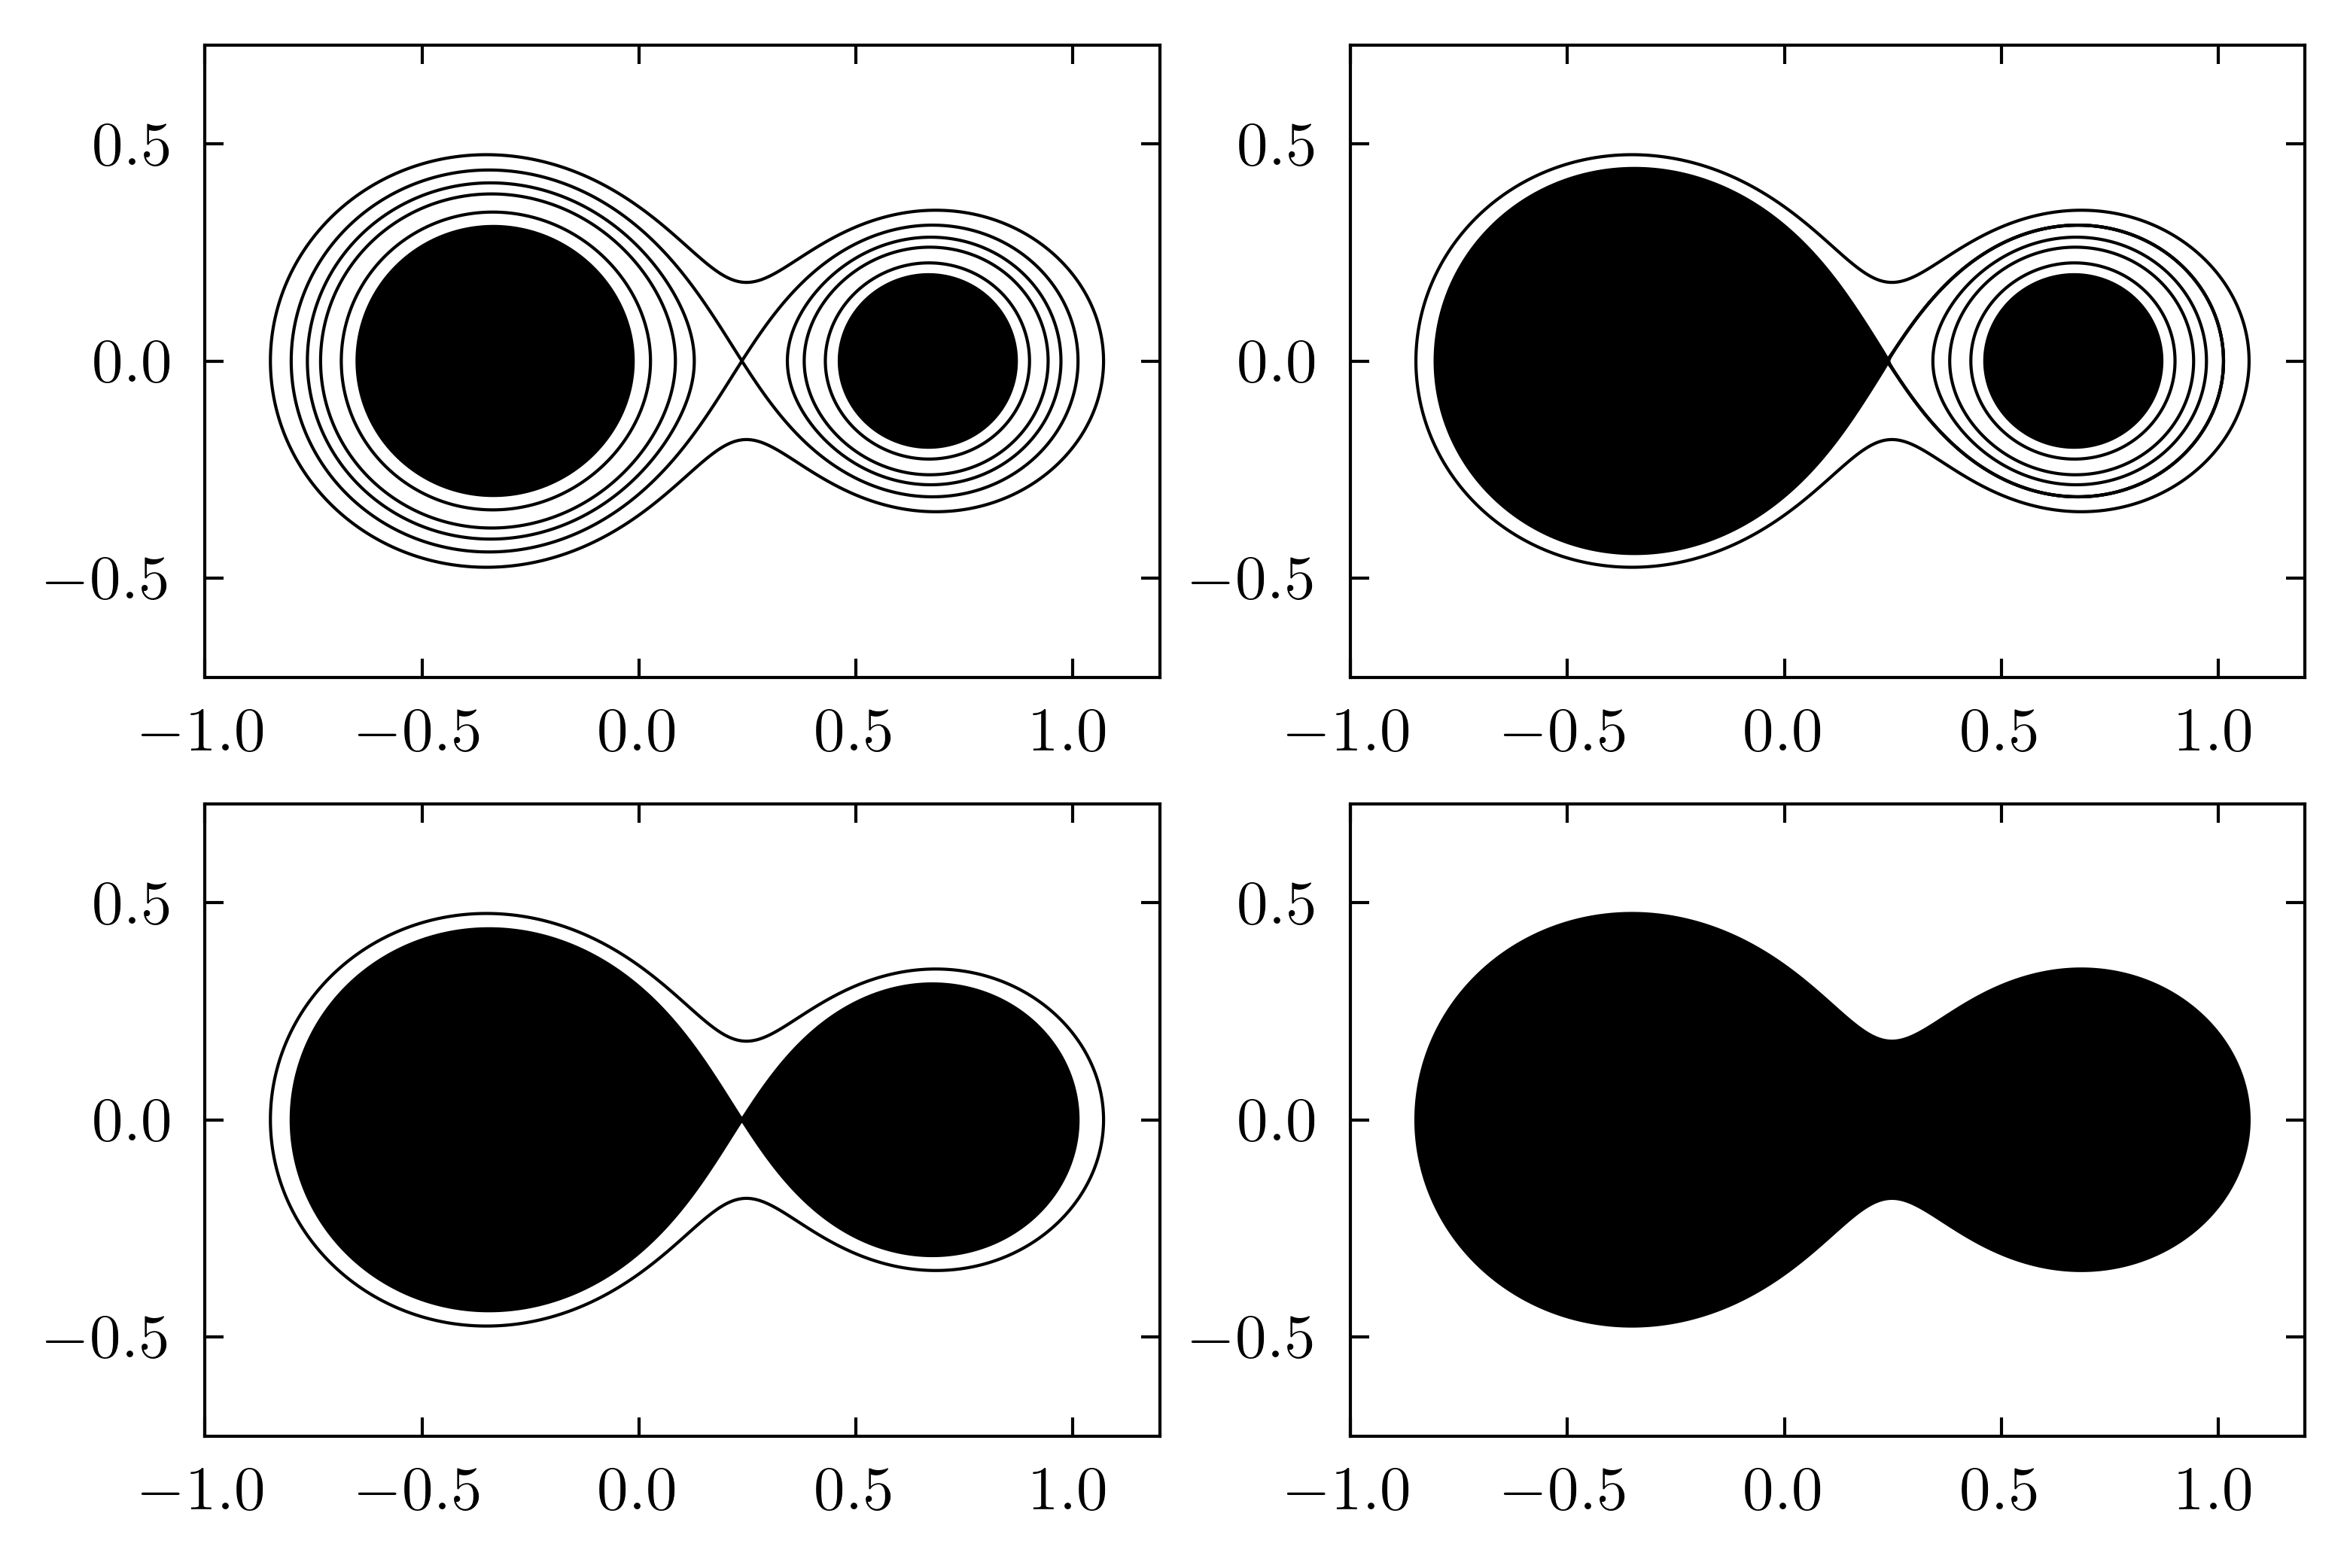

In [6]:
# Make the plot

fig,ax = plt.subplots(2,2,figsize=(wInches,hInches),dpi=dpi)

fig.subplots_adjust(wspace=0.2, hspace=0.2)

for i in [0,1]:
    for j in [0,1]:
        ax[i,j].tick_params('both',length=3,width=lwidth,which='major',direction='in',top='on',
                            labelsize=10,right='on')
        ax[i,j].tick_params('both',length=1.5,width=lwidth,which='minor',direction='in',top='on',right='on')
        ax[i,j].axis('equal')
        ax[i,j].set_xlim(-1.0, 1.2)
        ax[i,j].xaxis.set_major_locator(MultipleLocator(0.5))
        ax[i,j].set_ylim(-0.6, 0.6)
        ax[i,j].yaxis.set_major_locator(MultipleLocator(0.5))

# Make the plots

# Panel 1, upper left: detached binary, both stars inside the critical equipotential

cs = ax[0,0].contour(xi,eta,Ueff,levels=levels,colors='black',linestyles='solid',linewidths=0.5)
cf = ax[0,0].contourf(xi,eta,Ueff,levels=[-1000,phiL1-0.6],colors='black')

# Panel 2, upper right: semi-detached binary, primary fills its Roche lobe

cs = ax[0,1].contour(xi,eta,Ueff,levels=levels,colors='black',linestyles='solid',linewidths=0.5)
cf = ax[0,1].contourf(xi,eta,Ueff,levels=[-1000,phiL1-0.6],colors='black')

phiOff = 0.0001

rc = ax[0,1].contour(xi,eta,Ueff,levels=[phiL1+phiOff],colors='black',linestyles='solid',linewidths=0.5)

# uncomment if using matplotlib version 3.7, and comment out the 3.8++ hack below it (however,
# this is a message you need to update your matplotlib to >3.8):

# Very rude hack, avert your eyes - the roche lobe of the primary is path 1 in the contour
# found by trial and error, and the minor offset is arbitrary...

#p = rc.collections[0].get_paths()
#v = p[1].vertices
#xrc = v[:,0]
#yrc = v[:,1]
#ax[0,1].fill(xrc,yrc,color='black')

# 
# Extremely rude hack for matplotlib version 3.8 and above, avert your eyes!
#
# Part of the trick is to back off the roche-lobe contour level by 0.0001, the indices of the
# breakpoints in the three flattened paths and offset were found by trial and error...

rc = ax[0,1].contour(xi,eta,Ueff,levels=[phiL1-phiOff],colors='black',linestyles='solid',linewidths=0.5)

# matplotlib v>3.8 method:

p = rc.get_paths()
v = p[0].vertices
xrc = v[:,0]
yrc = v[:,1]

# there are 4 separate paths in the flattened paths (vertices v) returned by get_paths().  These
# are the 3 break points between them

brkPts = np.where(p[0].codes==1)[0] # code=1 is MoveTo

# the secondary contour is path 1 (start to break-point 0), the roche lobe contour of the primary is 
# path 3 (between break points 1 and 2)

ax[0,1].fill(xrc[:brkPts[0]],yrc[:brkPts[0]],color='black') 
ax[0,1].fill(xrc[brkPts[1]:brkPts[2]],yrc[brkPts[1]:brkPts[2]],color='black')        

# Panel 3, lower left: contact binary, both stars fill their Roche lobes

cs = ax[1,0].contour(xi,eta,Ueff,levels=levels,colors='black',linestyles='solid',linewidths=0.5)
cf = ax[1,0].contourf(xi,eta,Ueff,levels=[-1000,phiL1],colors='black')

# Panel 4, lower right: common-envelope binary, both stars overfill their Roche lobes, the
#          offset from phiL1 is arbitrary to look good

phiOff = 0.1
cs = ax[1,1].contour(xi,eta,Ueff,levels=levels,colors='black',linestyles='solid',linewidths=0.5)
cf = ax[1,1].contourf(xi,eta,Ueff,levels=[-1000,phiL1+phiOff],colors='black')

# plot it

plt.plot()
plt.savefig(plotFile,bbox_inches='tight',facecolor='white')